# NLP Project Demo

Demonstration of automated clustering of publicly traded US companies based on their business description data.

## Install Packages

In [1]:
!pip install matplotlib nltk numpy pandas scikit-learn scipy torch 

You should consider upgrading via the '/home/aaron/Documents/ML_UCL_MSc/NLP_COMP0087/venv-comp0087/bin/python -m pip install --upgrade pip' command.


## Imports

In [2]:
import os
import string
import pathlib
import pickle

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

In [5]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [6]:
import torch

In [7]:
%load_ext autoreload
%autoreload 2

from nvdm.models.nvdm import NVDM

## Helper Functions

In this section, we provide helper function definitions.

### Preprocessing

In [8]:
# Instance of Lemmatizer
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')

def preprocess_text(text):
    """ Process a single line of text. """

    # Strip trailing characters if any (e.g. newline)
    text_new = text.strip()
    
    # Remove puncuation
    text_new = ''.join(ch for ch in text_new if ch not in string.punctuation)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    
    text_new = ' '.join(tokens)

    return text_new

### Model Definitions

We experimented with three types of model:

- K-Means
- Latent Dirichlet Allocation (LDA)
- Neural Variational Document Modelling (NVDM)

For this demo, we only show the "best" model for each type. Please refer to the report and model-specific notebooks for details on hyperparameter selection.

In [2]:
class Model:
    """ Base class for clustering models.
    
    Basically a wrapper for a variety of models.
    """
    def __init__(self):
        pass
    
    def fit(self, X):
        """ Train the model. """
        raise NotImplementedError()
    
    def transform(self, X):
        """ Apply model to new data.
        
        Should output a topic-document matrix,
        where each element is a score indicating how likely the document
        should be assigned to the topic.
        For sklearn LDA, transform() does this by default.
        """
        raise NotImplementedError()
    
    @property
    def topic_vocab_matrix(self):
        """ Each model should be able to return a topic-vocab matrix
        containing a score (e.g. probability) of a word in the vocabulary
        occuring in the k^th topic. """
        pass
    
    # TODO: topic-document matrix
    # TODO: perplexity? Don't think K-Means has a notion of perplexity
    # (because we need probabilities).

    
class KMeansModel(Model):
    """ Wrapper for scikit-learn KMeans. """
    def __init__(self, num_topics):
        self.model = KMeans(
            n_clusters = num_topics,
            init='k-means++',
            max_iter = 300,
            n_init = 10,
            random_state = 0,
            verbose = False)
    
    def fit(self, X):
        self.model.fit(X)

    def transform(self, X):
        """ Returns a topic-document matrix of distances per cluster. """
        return self.model.transform(X)
    
    @property
    def topic_vocab_matrix(self):
        """ Return K-Means clusters.
        
        ndarray of shape (num_topics, n_features)
        """
        return self.model.cluster_centers_


class LDAModel(Model):
    """ Wrapper for scikit-learn LDA. """
    def __init__(self, num_topics):
        self.model = LatentDirichletAllocation(
            n_components=num_topics,
            max_iter=5,
            learning_method='online',
            learning_offset=50.,
            random_state=0)
    
    def fit(self, X):
        self.model.fit(X)
    
    def transform(self, X):
        """ Returns a topic-document matrix of probabilities. """
        return self.model.transform(X)
    
    @property
    def topic_vocab_matrix(self):
        """ Gets the components_ attribute of LDA, normalized
        
        Quoting sklearn docs:
        Variational parameters for topic word distribution.
        Since the complete conditional for topic word distribution is a Dirichlet,
        components_[i, j] can be viewed as pseudocount that represents
        the number of times word j was assigned to topic i.
        It can also be viewed as distribution over the words for each topic after normalization:
        model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
        """
        # return self.model.components_
        return self.model.components_ / self.model.components_.sum(axis=1)[:, np.newaxis]

class NVDMModel(Model):
    """ PyTorch NVDM model.
    
    Loads a pretrained model from disk.
    """
    def __init__(self, model_path, vocab_size, hidden_size=500, num_topics=300):
        self.model = NVDM(vocab_size, hidden_size, num_topics, 1, "cpu")
        self.model.load_state_dict(torch.load(model_path, map_location="cpu"))
        self.model.eval()
        
        decoder = self.model.decoder[0]
        weights = decoder.weight.data.detach().clone().cpu().numpy()
        self.topic_vocab = weights.T
    
    def fit(self, X):
        """ We don't train the model here because it takes too long. """
        pass
    
    def transform(self, X):
        """ Output a topic-document matrix. """
        n_doc, n_vocab = X.shape
        n_topic = self.topic_vocab.shape[0]
        
        # shape (n_doc, n_topic)
        # Score of each document for a topic is the average scores
        # of the document's words in the topic.
        topic_doc = X @ self.topic_vocab.T
        
        # Optionally, normalize by document length.
        topic_doc = topic_doc / X.sum(axis=1, keepdims=True)
        
        return topic_doc
    
    def transform_encoder(self, X):
        """ Output a topic-document matrix using encoder latent output.
        
        Each document's representation is the Gaussian mean parameter vector
        output by the encoder.
        """
        X = torch.tensor(X, dtype=int)
        _, mu, _ = self.model.encoder(X)
        topic_doc = mu.numpy()
        return topic_doc
    
    @property
    def topic_vocab_matrix(self):
        """ Returns the learned semantic embeddings of each word. """
        return self.topic_vocab

### Evaluation

We provide functions for evaluation below.
The _topic coherence_ metric is used. TODO perplexity for LDA and NVDM.

In [10]:
# Topic coherence.
def umass_score(tf):
    """ Compute topic coherence using UMass metric.
    
    Ref: http://qpleple.com/topic-coherence-to-evaluate-topic-models/
    
    tf: term-frequency matrix for each document.
        Each i^th row is the BOW representation of the i^th document.
    """
    
    # D(wi): count of documents containing the word wi (i.e. df)
    Dwi = np.array(np.sum(tf > 0, axis=0))[0]

    W_bin = np.zeros_like(tf)
    W_bin[tf > 0] = 1
    
    # D(wi, wj): count of documents containing both words wi and wj
    Dwi_wj = W_bin.T @ W_bin

    score_umass = np.log((Dwi_wj + 1)/ Dwi)
    
    return score_umass

def topic_coherence(topic_vocab, n_top_words, pair_score):
    """ Compute the topic coherence of each topic,
    given a learned topic-vocabulary matrix, the number of top words to use
    and a matrix of pairwise scores (e.g. umass_score output)
    
    topic_vocab: dimensions (number of topics, vocabulary size).
    model.components_ for LDA, and the "semantic embedding" matrix in the decoder for NVDM.
    
    pair_score: matrix of scores (e.g. UMass)
    """
    coherences = []
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

def plot_top_words(topic_vocab, feature_names, n_top_words, title):
    """ Given a topic-vocabulary matrix containing scores
    (e.g. probabilities, higher the better),
    plot the top words as a frequency bar-graph for each topic.
    
    e.g. set topic_vocab=model._components for LDA.
    """
    K = len(topic_vocab)
    n_x = 5
    n_y = int(np.ceil(K / n_x))
    fig, axes = plt.subplots(n_y, n_x, figsize=(2.5 * n_x, 4 * n_y), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    # plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    fig.tight_layout()
    plt.show()

### Data-Loading

Functions for loading all business description datasets (S&P500 and bds1).

In [11]:
def load_sp500(path, preprocess=False):
    """ Load S&P500 data from the per-company text files in the supplied directory path.
    
    Within the directory, each file is named "<ticker>_<sector>.txt".
    Each contains the business description (BD) of the company.
    
    If preprocess is True, the preprocess the business descriptions at the same time.
    """
    filenames = os.listdir(path)

    tickers = []
    sectors = []
    bds = []
    for fn in filenames:
        prefix = fn.split('.txt')[0]
        ticker, sector = prefix.split('_')
        filepath = os.path.join(path, fn)
        with open(filepath, 'r', encoding="utf8") as f:
            bd = f.read().strip()
        
        if preprocess:
            bd = preprocess_text(bd)

        tickers.append(ticker)
        sectors.append(sector)
        bds.append(bd)
    
    return tickers, sectors, bds


def load_bds1(path, preprocess=False, exclude_tickers=None):
    """ Load data from the business data, given the file path (e.g. "data/bds_1.txt").
    
    In the file, each company has two consecutive lines.
    The first line is <company ticker>:<CIK> (we only care about the ticker)
    and the second line is the company business description.
    
    exclude_tickers is a list of tickers that we want to ignore in bds_1.txt.
    For example, we can use this to exclude any S&P500 companies to avoid
    overlapping of datasets.
    """
    
    with open(path, "r", encoding="utf8") as f:
        lines = f.readlines()

    company_ids_all = [ln.strip() for ln in lines[0::2]]
    company_descriptions_all = [ln.strip() for ln in lines[1::2]]
    company_tickers = [x.split(':')[0] for x in company_ids_all]

    exclusion_set = set(exclude_tickers) if exclude_tickers is not None else set()

    tickers = []
    bds = []
    
    # Some business descriptions are too short (or even empty),
    # so we only keep those with a length (number of characters) deemed reasonable.
    bd_valid_length = 3000
    for ticker, bd in zip(company_tickers, company_descriptions_all):
        if ticker not in exclusion_set and len(bd) >= bd_valid_length:
            tickers.append(ticker)
            
            if preprocess:
                bd = preprocess_text(bd)
            bds.append(bd)
    
    return tickers, bds

def load_ticker_name(filepath='./S AND P.xlsx'):
    """ Load a dictionary that converts tickers to security names.
    
    e.g. ticker_to_name["MSFT"] = "Microsoft Corp."
    """
    # Company information (ticker, name, industry sector etc.)
    company_df = pd.read_excel("./S AND P.xlsx")
    ticker_names = company_df[['Symbol', 'Security']].to_dict(orient='records')
    ticker_to_name = dict()

    for item in ticker_names:
        ticker = item['Symbol']
        name = item['Security']

        ticker_to_name[ticker] = name
    
    return ticker_to_name

## Begin Demo

In [12]:
%%time
# Load and preprocess S&P500 and BDS1 data.
# We use BDS1 as the training set and S&P500 as the validation set.
sp500_tickers, sp500_sectors, sp500_bds = load_sp500("./SP500", preprocess=True)
bds1_tickers, bds1_bds = load_bds1("./nvdm/data/bds_1.txt", preprocess=True, exclude_tickers=sp500_tickers)

CPU times: user 1min 2s, sys: 288 ms, total: 1min 2s
Wall time: 1min 2s


In [13]:
# FEATURE EXTRACTION
# Use this to convert text to a Bag-of-Words (term-frequency) representation.
# We "train" this vectorizer on S&P500 only, assuming the BDS1 validation set is "unseen".
# When evaluating, if a word in a business description from BDS1 doesn't exist in S&P500 data,
# then it will be ignored.

# Only keep top n most frequent words (adjust futher if required)
# These parameters (except stopwords, since they are already removed)
# were used in LDA notebooks. Adjust if needed.
n_features = 4000
tf_vectorizer = CountVectorizer(max_features=n_features, max_df=0.95, min_df=2)
tf_vectorizer.fit(sp500_bds)

CountVectorizer(max_df=0.95, max_features=4000, min_df=2)

In [14]:
X_sp500 = tf_vectorizer.transform(sp500_bds).toarray()

In [15]:
# TODO: save count vectorizer.

### K-Means

In [16]:
kmeans = KMeansModel(15)
kmeans.fit(X_sp500)

In [19]:
# with open("modelsaves/kmeans_temp.pickle", "wb") as f:
#     pickle.dump(kmeans.model, f)

In [17]:
preds = kmeans.transform(X_sp500)

In [149]:
# Group the companies by the most likely topic assignment.
# Argmin, because K-Means.transform() outputs distances of companies to each cluster,
# so we want the topic with the smallest distance.
# (in contrast with LDA, which outputs topic probabilities, so we want argmax)
topic_per_company = preds.argmin(axis=1)
groups = dict((i, []) for i in range(len(topic_per_company)))
for company_idx in range(len(topic_per_company)):
    topic = topic_per_company[company_idx]
    groups[topic].append(company_idx)

In [150]:
# Show the tickers for an example group
# Compare them to their actual industry sector
[(sp500_tickers[i], sp500_sectors[i]) for i in groups[0]]

[('BRK.B', 'Financials'),
 ('FDX', 'Industrials'),
 ('AAL', 'Industrials'),
 ('MGM', 'Consumer Discretionary'),
 ('WY', 'Real Estate'),
 ('L', 'Financials'),
 ('CF', 'Materials'),
 ('PVH', 'Consumer Discretionary'),
 ('RL', 'Consumer Discretionary'),
 ('MOS', 'Materials'),
 ('BXP', 'Real Estate'),
 ('HST', 'Real Estate'),
 ('WM', 'Industrials'),
 ('HES', 'Energy'),
 ('NCLH', 'Consumer Discretionary'),
 ('ORLY', 'Consumer Discretionary'),
 ('DAL', 'Industrials'),
 ('YUM', 'Consumer Discretionary'),
 ('HFC', 'Energy'),
 ('UDR', 'Real Estate'),
 ('CHRW', 'Industrials'),
 ('RSG', 'Industrials'),
 ('HAS', 'Consumer Discretionary'),
 ('MRO', 'Energy'),
 ('EMN', 'Materials'),
 ('GM', 'Consumer Discretionary'),
 ('BKR', 'Energy'),
 ('NUE', 'Materials'),
 ('TAP', 'Consumer Staples'),
 ('AWK', 'Utilities'),
 ('WAB', 'Industrials'),
 ('CCL', 'Consumer Discretionary'),
 ('LYB', 'Materials'),
 ('CMI', 'Industrials'),
 ('EXPD', 'Industrials'),
 ('DRI', 'Consumer Discretionary'),
 ('ECL', 'Materials'

In [93]:
kmeans_topic_coherence = topic_coherence(kmeans.topic_vocab_matrix, 10, umass_score(X_sp500))
print(np.median(kmeans_topic_coherence))

71.2635636989456


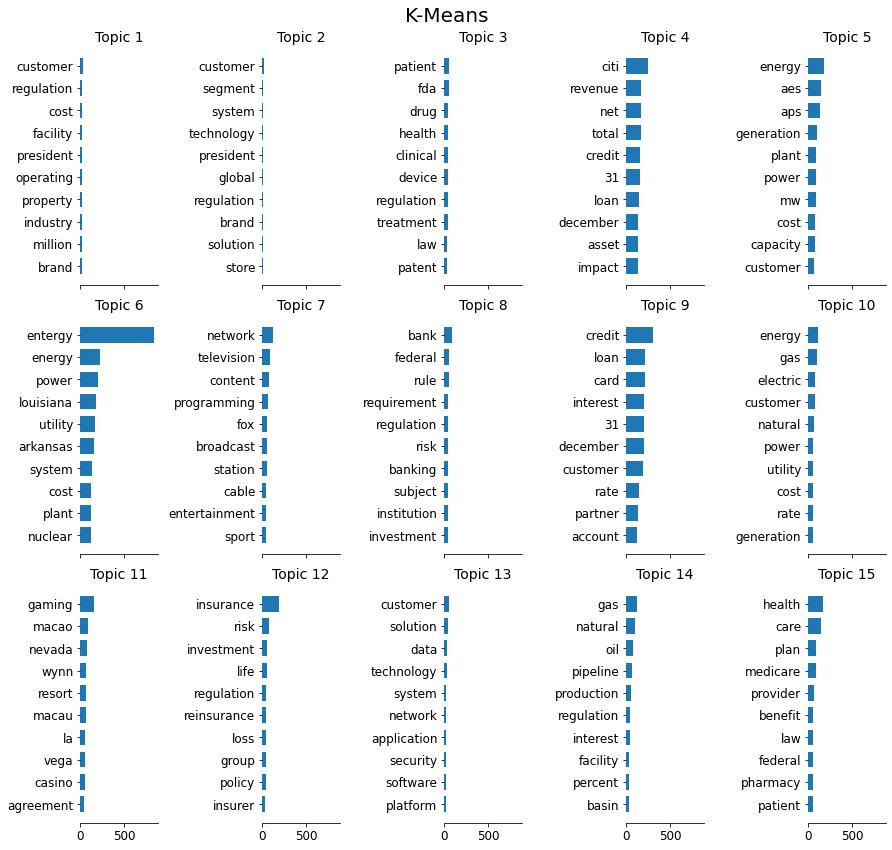

In [151]:
plot_top_words(kmeans.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "K-Means")

### LDA

In [15]:
lda = LDAModel(15)
lda.fit(X_sp500)

In [16]:
preds = lda.transform(X_sp500)

In [17]:
# Group the companies by the most likely topic assignment.
# argmax because we want the topic with highest probability.
topic_per_company = preds.argmax(axis=1)
groups = dict((i, []) for i in range(len(topic_per_company)))
for company_idx in range(len(topic_per_company)):
    topic = topic_per_company[company_idx]
    groups[topic].append(company_idx)

In [18]:
# Show the tickers for an example group
# Compare them to their actual industry sector
[(sp500_tickers[i], sp500_sectors[i]) for i in groups[12]]

[('PFG', 'Financials'),
 ('AIG', 'Financials'),
 ('WLTW', 'Financials'),
 ('CINF', 'Financials'),
 ('RE', 'Financials'),
 ('PRU', 'Financials'),
 ('AJG', 'Financials'),
 ('AIZ', 'Financials'),
 ('TRV', 'Financials'),
 ('CB', 'Financials'),
 ('ALL', 'Financials'),
 ('AON', 'Financials'),
 ('MMC', 'Financials'),
 ('UNM', 'Financials'),
 ('AFL', 'Financials'),
 ('CI', 'Health Care'),
 ('LNC', 'Financials'),
 ('MET', 'Financials'),
 ('PGR', 'Financials'),
 ('GL', 'Financials'),
 ('WRB', 'Financials'),
 ('HIG', 'Financials')]

In [19]:
lda_topic_coherence = topic_coherence(lda.topic_vocab_matrix, 10, umass_score(X_sp500))
print(np.mean(lda_topic_coherence))

39.342870993697055


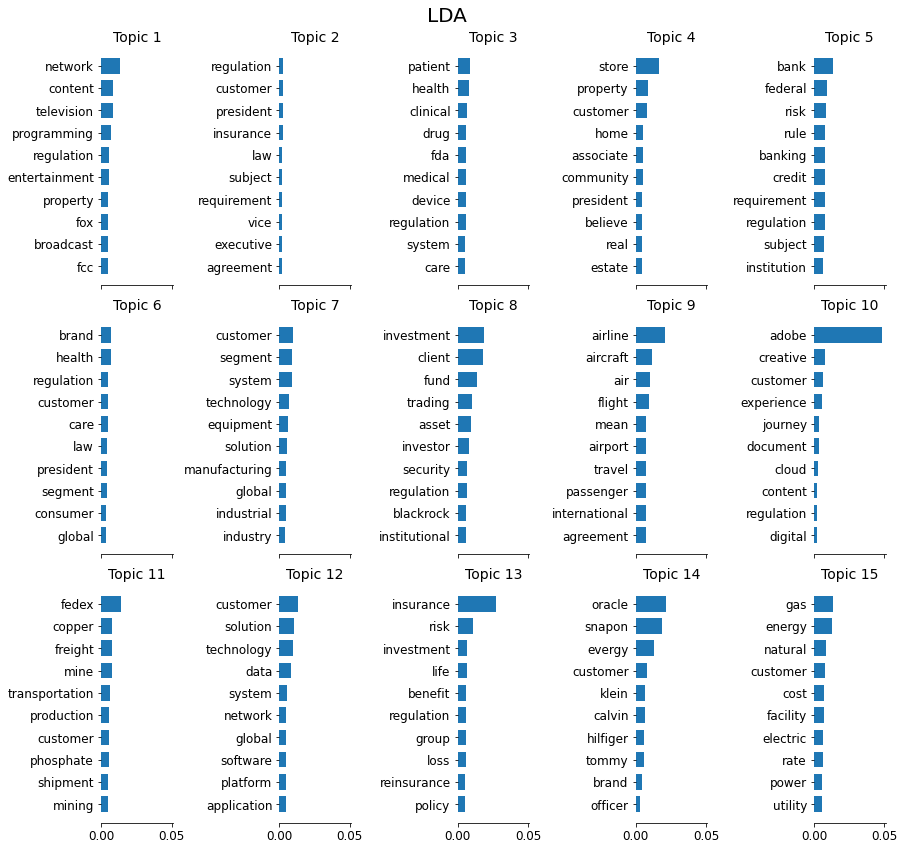

In [20]:
plot_top_words(lda.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "LDA")

### NVDM

In [24]:
nvdm = NVDMModel("./nvdm/modelsaves/nvdm_k300_1000epochs.pt", len(tf_vectorizer.get_feature_names()))

In [25]:
preds = nvdm.transform(X_sp500)

In [70]:
# Group the companies by the most likely topic assignment.
# Argmin, because K-Means.transform() outputs distances of companies to each cluster,
# so we want the topic with the smallest distance.
# (in contrast with LDA, which outputs topic probabilities, so we want argmax)
topic_per_company = preds.argmax(axis=1)
groups = dict((i, []) for i in range(len(topic_per_company)))
for company_idx in range(len(topic_per_company)):
    topic = topic_per_company[company_idx]
    groups[topic].append(company_idx)

In [81]:
# Show the tickers for an example group
# Compare them to their actual industry sector
print([key for key, val in groups.items() if len(val) > 0])
[(sp500_tickers[i], sp500_sectors[i]) for i in groups[50]]

[8, 18, 21, 26, 50, 61, 70, 81, 90, 94, 136, 179, 190, 210, 271, 286]


[('AEE', 'Utilities'),
 ('AAL', 'Industrials'),
 ('NOC', 'Industrials'),
 ('NSC', 'Industrials'),
 ('SO', 'Utilities'),
 ('SRE', 'Utilities'),
 ('ES', 'Utilities'),
 ('DLTR', 'Consumer Discretionary'),
 ('LRCX', 'Information Technology'),
 ('EXC', 'Utilities'),
 ('MOS', 'Materials'),
 ('PKG', 'Materials'),
 ('ED', 'Utilities'),
 ('XEL', 'Utilities'),
 ('FE', 'Utilities'),
 ('CMS', 'Utilities'),
 ('PPL', 'Utilities'),
 ('WEC', 'Utilities'),
 ('LHX', 'Industrials'),
 ('EVRG', 'Utilities'),
 ('ATO', 'Utilities'),
 ('GPC', 'Consumer Discretionary'),
 ('MCHP', 'Information Technology'),
 ('AZO', 'Consumer Discretionary'),
 ('PEG', 'Utilities'),
 ('CSX', 'Industrials'),
 ('NUE', 'Materials'),
 ('NRG', 'Utilities'),
 ('SWKS', 'Information Technology'),
 ('CNP', 'Utilities'),
 ('NI', 'Utilities'),
 ('D', 'Utilities'),
 ('LNT', 'Utilities'),
 ('ETR', 'Utilities'),
 ('NEE', 'Utilities'),
 ('HWM', 'Industrials'),
 ('AES', 'Utilities'),
 ('MPWR', 'Information Technology'),
 ('DUK', 'Utilities'),
 

In [72]:
nvdm_topic_coherence = topic_coherence(nvdm.topic_vocab_matrix, 10, umass_score(X_sp500))
print(np.mean(nvdm_topic_coherence))

KeyboardInterrupt: 

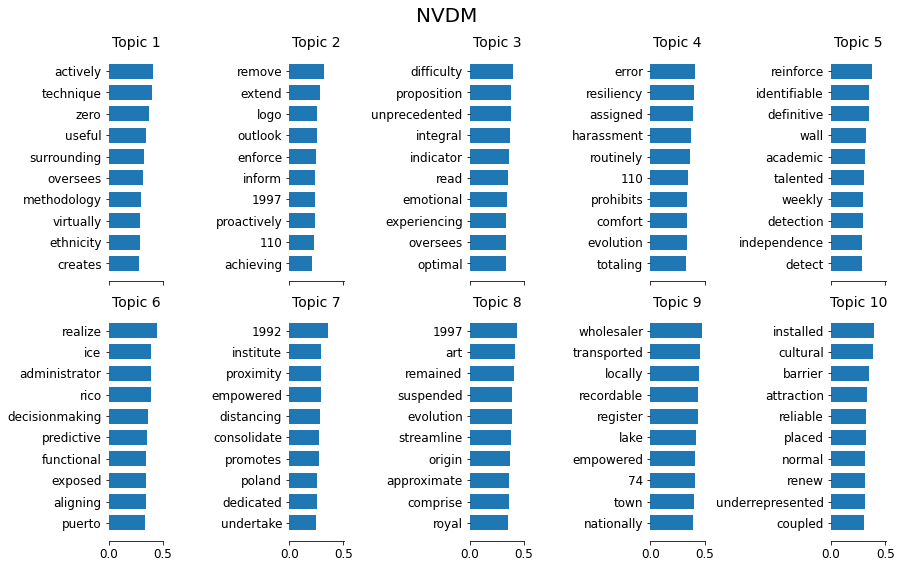

In [58]:
# Since there are too many topics (300),
# we only sample a few.

#idx = np.array(nvdm_topic_coherence).argsort()[:-10 - 1:-1]
idx = np.random.choice(nvdm.topic_vocab_matrix.shape[0], size=10)
plot_top_words(nvdm.topic_vocab_matrix[idx], tf_vectorizer.get_feature_names(), 10, "NVDM")

# Interactive

In [26]:
# Show the tickers for an example group
# Compare them to their actual industry sector
ticker_to_name = load_ticker_name('./S AND P.xlsx')
print("Non-empty groups:")
print([key for key, val in groups.items() if len(val) > 0])

print("Example group: topic 50")
[(sp500_tickers[i], ticker_to_name[sp500_tickers[i]], sp500_sectors[i]) for i in groups[2]]

Non-empty groups:
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14]
Example group: topic 50


[('BIIB', 'Biogen Inc.', 'Health Care'),
 ('ABT', 'Abbott Laboratories', 'Health Care'),
 ('HOLX', 'Hologic', 'Health Care'),
 ('ALXN', 'Alexion Pharmaceuticals', 'Health Care'),
 ('VAR', 'Varian Medical Systems', 'Health Care'),
 ('XRAY', 'Dentsply Sirona', 'Health Care'),
 ('SYK', 'Stryker Corp.', 'Health Care'),
 ('DHR', 'Danaher Corp.', 'Health Care'),
 ('PFE', 'Pfizer Inc.', 'Health Care'),
 ('COO', 'The Cooper Companies', 'Health Care'),
 ('RMD', 'ResMed', 'Health Care'),
 ('HSIC', 'Henry Schein', 'Health Care'),
 ('GILD', 'Gilead Sciences', 'Health Care'),
 ('TMO', 'Thermo Fisher Scientific', 'Health Care'),
 ('INCY', 'Incyte', 'Health Care'),
 ('BSX', 'Boston Scientific', 'Health Care'),
 ('DGX', 'Quest Diagnostics', 'Health Care'),
 ('HCA', 'HCA Healthcare', 'Health Care'),
 ('REGN', 'Regeneron Pharmaceuticals', 'Health Care'),
 ('ISRG', 'Intuitive Surgical Inc.', 'Health Care'),
 ('IDXX', 'Idexx Laboratories', 'Health Care'),
 ('AMGN', 'Amgen Inc.', 'Health Care'),
 ('BMY', '

Enter any English business description in the prompt below. For example, choose a company, copy its description from EDGAR/Wikipedia etc. and paste it below. You could also type in your own.

In [39]:
def interactive_demo():

    # LDA example
    #test_name = input("Enter a company name: ")  # doesn't do anything apart from print
    test_bd = input("Enter business description: ")
    test_bd = preprocess_text(test_bd)
    X_test = tf_vectorizer.transform([test_bd]).toarray()

    test_scores = lda.transform(X_test)

    test_topic = test_scores.argmax()
    print(f"Your company was assigned to topic {test_topic}.")
    print(f"Other companies with the same topic assignment:")

    # Compute best topic assignments for all companies in S&P500
    all_scores = lda.transform(X_sp500)
    topic_per_company = all_scores.argmax(axis=1)
    groups = dict((i, []) for i in range(len(topic_per_company)))
    for company_idx in range(len(topic_per_company)):
        topic = topic_per_company[company_idx]
        groups[topic].append(company_idx)

    # Print S&P500 companies that are in the custom company's group (topic assignment)
    for i in groups[test_topic][:10]:
        print(sp500_tickers[i], ticker_to_name.get(sp500_tickers[i]), sp500_sectors[i])

In [40]:
# Examples to copy from
# https://en.wikipedia.org/wiki/Novartis (pharma)
# https://en.wikipedia.org/wiki/WeWork (real estate)
interactive_demo()

Enter business description: sadf
Your company was assigned to topic 0.
Other companies with the same topic assignment:
TMUS T-Mobile US Communication Services
NWSA News Corp (Class A) Communication Services
DIS The Walt Disney Company Communication Services
LYV Live Nation Entertainment Communication Services
CHTR Charter Communications Communication Services
CCI Crown Castle Real Estate
PENN Penn National Gaming Consumer Discretionary
DISH Dish Network Communication Services
AMT American Tower Corp. Real Estate
NWS News Corp (Class B) Communication Services


In [36]:
"""
Novartis International AG is a Swiss multinational pharmaceutical company based in Basel, Switzerland. It is one of the largest pharmaceutical companies in the world.

Novartis manufactures the drugs clozapine (Clozaril), diclofenac (Voltaren)(sold to Glaxo Smith Kline in 2015 deal), carbamazepine (Tegretol), valsartan (Diovan), imatinib mesylate (Gleevec/Glivec), cyclosporine (Neoral/Sandimmune), letrozole (Femara), methylphenidate (Ritalin) (production ceased 2020), terbinafine (Lamisil), deferasirox (Exjade), and others.

In March 1996, Ciba-Geigy merged with Sandoz; the pharmaceutical and agrochemical divisions of both companies formed Novartis as an independent entity. Other Ciba-Geigy and Sandoz businesses were sold, or, like Ciba Specialty Chemicals, spun off as independent companies. The Sandoz brand disappeared for three years, but was revived in 2003 when Novartis consolidated its generic drugs businesses into a single subsidiary and named it Sandoz. Novartis divested its agrochemical and genetically modified crops business in 2000 with the spinout of Syngenta in partnership with AstraZeneca, which also divested its agrochemical business.

Novartis is a full member of the European Federation of Pharmaceutical Industries and Associations (EFPIA),[4] the International Federation of Pharmaceutical Manufacturers and Associations (IFPMA),[5] and the Pharmaceutical Research and Manufacturers of America (PhRMA).[6] 
"""

'\nNovartis International AG is a Swiss multinational pharmaceutical company based in Basel, Switzerland. It is one of the largest pharmaceutical companies in the world.\n\nNovartis manufactures the drugs clozapine (Clozaril), diclofenac (Voltaren)(sold to Glaxo Smith Kline in 2015 deal), carbamazepine (Tegretol), valsartan (Diovan), imatinib mesylate (Gleevec/Glivec), cyclosporine (Neoral/Sandimmune), letrozole (Femara), methylphenidate (Ritalin) (production ceased 2020), terbinafine (Lamisil), deferasirox (Exjade), and others.\n\nIn March 1996, Ciba-Geigy merged with Sandoz; the pharmaceutical and agrochemical divisions of both companies formed Novartis as an independent entity. Other Ciba-Geigy and Sandoz businesses were sold, or, like Ciba Specialty Chemicals, spun off as independent companies. The Sandoz brand disappeared for three years, but was revived in 2003 when Novartis consolidated its generic drugs businesses into a single subsidiary and named it Sandoz. Novartis divested 